In [4]:
import glob
import json
import os

import librosa
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

import utils
import plot_utils

# listen to audios
import IPython.display as ipd

In [46]:
import plots

In [47]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
%autoreload 2

# Compute MM-SHAP values

In [9]:
qfs = pd.read_json("../data/output_data/qwen_fs.json")
qzs = pd.read_json("../data/output_data/qwen_zs.json")
mfs = pd.read_json("../data/output_data/mullama_fs.json")
mzs = pd.read_json("../data/output_data/mullama_zs.json")

qfs = utils.parse_df(qfs)
qzs = utils.parse_df(qzs)
mfs = utils.parse_df(mfs)
mzs = utils.parse_df(mzs)

/home/gigibs/Documents/research/2025_investigating_mmshap/src/experiments/mmshap.py:17: RuntimeWarning: invalid value encountered in scalar divide
  text_score = text_contrib / (text_contrib + audio_contrib)
/home/gigibs/Documents/research/2025_investigating_mmshap/src/experiments/mmshap.py:18: RuntimeWarning: invalid value encountered in scalar divide
  audio_score = audio_contrib / (text_contrib + audio_contrib)
/home/gigibs/Documents/research/2025_investigating_mmshap/src/experiments/mmshap.py:17: RuntimeWarning: invalid value encountered in scalar divide
  text_score = text_contrib / (text_contrib + audio_contrib)
/home/gigibs/Documents/research/2025_investigating_mmshap/src/experiments/mmshap.py:18: RuntimeWarning: invalid value encountered in scalar divide
  audio_score = audio_contrib / (text_contrib + audio_contrib)


qfs accuracy = 0.4426229508196721
qzs accuracy = 1.0
mfs accuracy = 0.27014218009478674
mzs accuracy = 0.3277661795407098


In [127]:
def get_values(row):
    question_id =  row.name
    # dataset_path = "/media/gigibs/DD02EEEC68459F17/datasets"
    # dataset_path = "/scratch/gv2167/datasets/"
    dataset_path = "."
    
    data = f"../{row['output_folder']}/{question_id}_info.npz"
    data = np.load(data)
    tokens = row["input_ids"]
    audio_tokens = np.where(tokens < 0)[-1]
    question_tokens = np.where(tokens >= 0)[-1]
    
    all_shapley_values = data["shapley_values"].squeeze(0).squeeze(0)
    audio_shapley_values = all_shapley_values[audio_tokens]
    question_shapley_values = all_shapley_values[question_tokens]

    return all_shapley_values, audio_shapley_values, question_shapley_values

# Inspect Values

In [83]:
qfs[qfs["final_answer"] == 1][["question", "a_shap", "input_tokens", "output_tokens"]].sort_values(by="a_shap", ascending=False)

question    a_shap  \
question_id                                                                
586          Which instruments contribute to the main melod...  0.313072   
550          What is a possible practical use for the recor...  0.311090   
427          What does the male vocalist do at the end of t...  0.301570   
615          What is the tempo of the music?\n Options: (A)...  0.294316   
335          Which percussive instrument provides the rhyth...  0.293183   
...                                                        ...       ...   
711          Which effect is applied to the e-guitar in thi...  0.180715   
546          Which genre best describes the music piece?\n ...  0.177917   
722          What overall feeling does the music convey?\n ...  0.166923   
506          Which instrument takes the lead in the song's ...  0.155804   
507          How would you characterize the tempo of the so...  0.155525   

                                                  input_tokens  \
question_id                                                      
586          [\n, Question, :,  What,  rhythm,  pattern,  d...   
550          [\n, Question, :,  What,  rhythm,  pattern,  d...   
427          [\n, Question, :,  What,  rhythm,  pattern,  d...   
615          [\n, Question, :,  What,  rhythm,  pattern,  d...   
335          [\n, Question, :,  What,  rhythm,  pattern,  d...   
...                                                        ...   
711          [\n, Question, :,  What,  rhythm,  pattern,  d...   
546          [\n, Question, :,  What,  rhythm,  pattern,  d...   
722          [\n, Question, :,  What,  rhythm,  pattern,  d...   
506          [\n, Question, :,  What,  rhythm,  pattern,  d...   
507          [\n, Question, :,  What,  rhythm,  pattern,  d...   

                                                 output_tokens  
question_id                                                     
586          [The,  main,  melody,  of,  the,  piece,  is, ...  
550          [The,  recorded,  material,  can,  be,  used, ...  
427          [The,  male,  vocalist,  laughs,  at,  the,  e...  
615          [The,  tempo,  of,  the,  music,  is,  medium, .]  
335          [The,  rhyth, mic,  background,  in,  this,  p...  
...                                                        ...  
711          [The,  correct,  answer,  is, :,  (, D, ),  Pi...  
546          [The,  genre,  of,  the,  music,  piece,  is, ...  
722          [The,  overall,  feeling,  of,  the,  music,  ...  
506          [The,  correct,  answer,  is, :,  C, ),  Guita...  
507          [The,  tempo,  of,  the,  song,  is,  medium, ...  

[216 rows x 4 columns]

## Bell Example (question_id = 719)

In [135]:
# annotations for this audio
gt_start = 5.6
gt_end = 7

### QwenAudio - few shot

In [131]:
sample = qfs.loc[719]

In [132]:
all_shapley_values, audio_shapley_values, question_shapley_values = get_values(sample)

In [133]:
x, fs = librosa.load(os.path.join(dataset_path, sample["audio_path"]), sr=16000)
ipd.Audio(x, rate=fs)

Plot aggregated results

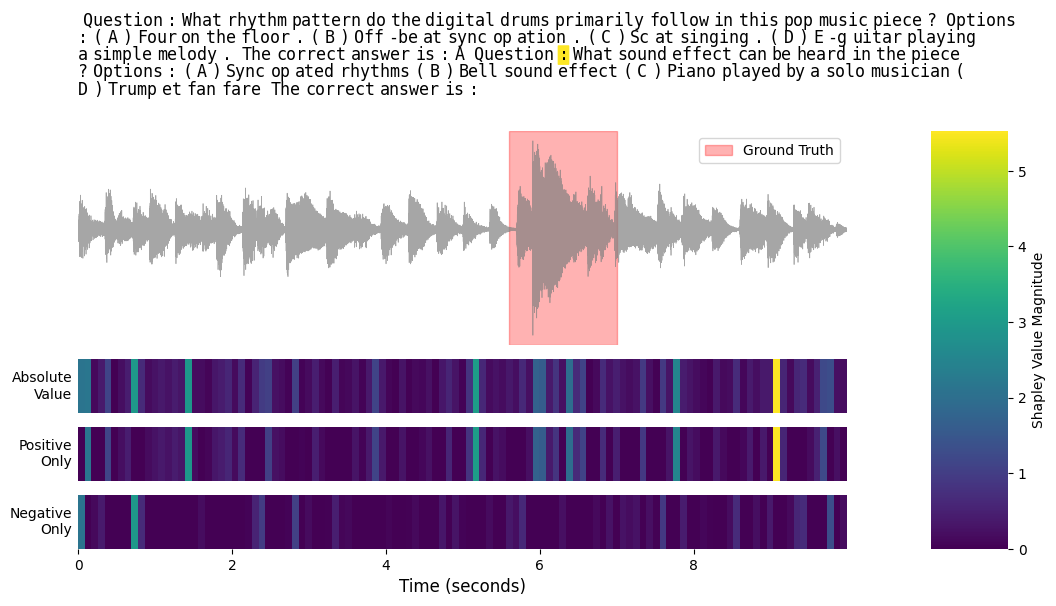

In [137]:
highlighted_text = plots.visualize_shapley_analysis(
        text_shapley_values=question_shapley_values,
        question_tokens=sample["input_tokens"],
        answer_tokens=sample["output_tokens"],
        audio_signal=x,
        audio_shapley_values=audio_shapley_values,
        sample_rate=16000,
        gt_start=gt_start,
        gt_end=gt_end,
        idx=None,
        figsize=(12,7),
        colormap="viridis",
        threshold=0.8
    )

Plot results per index

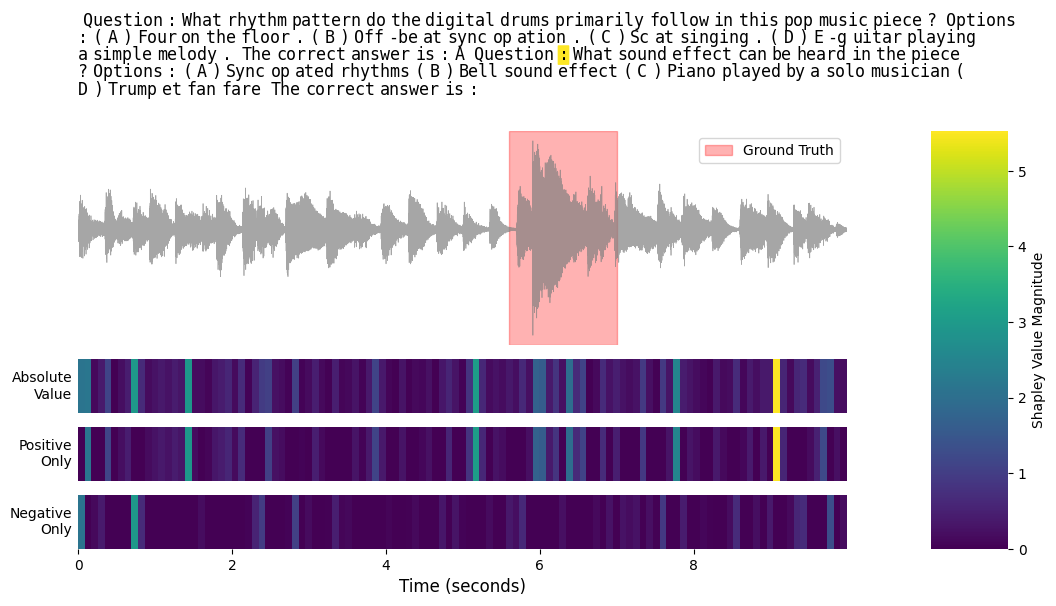

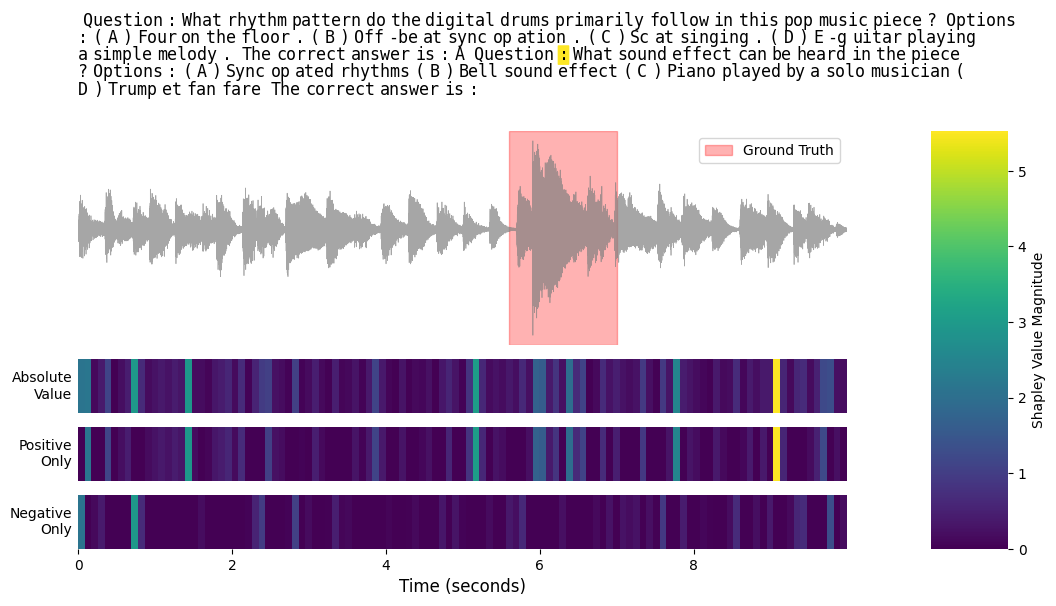

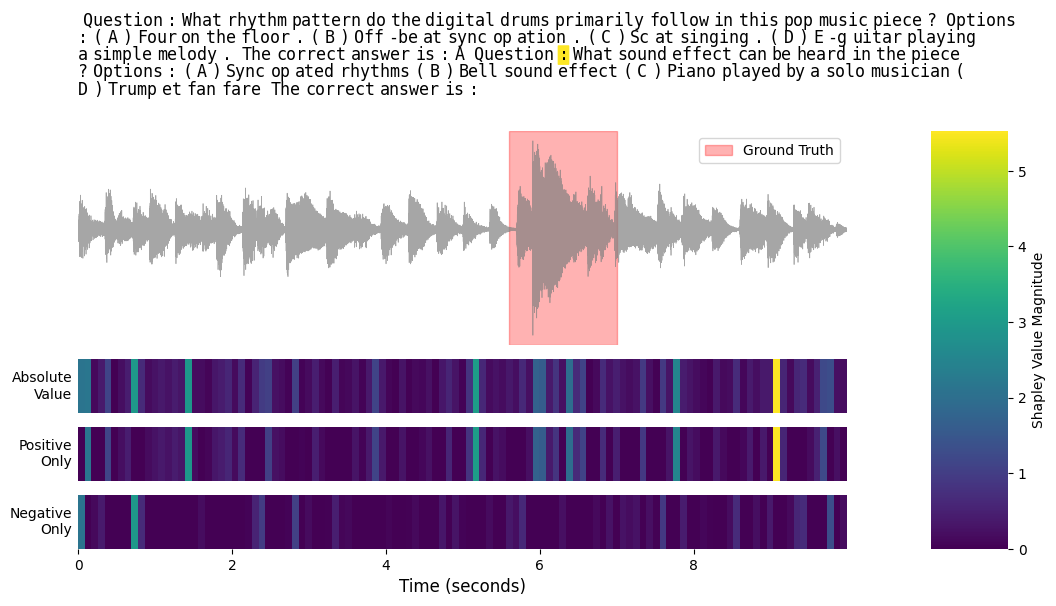

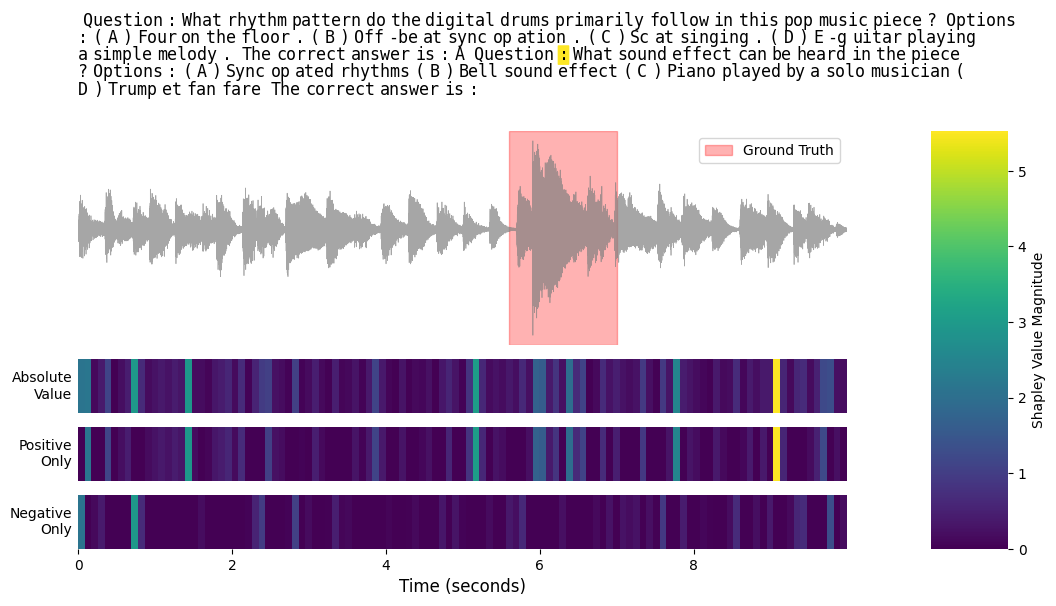

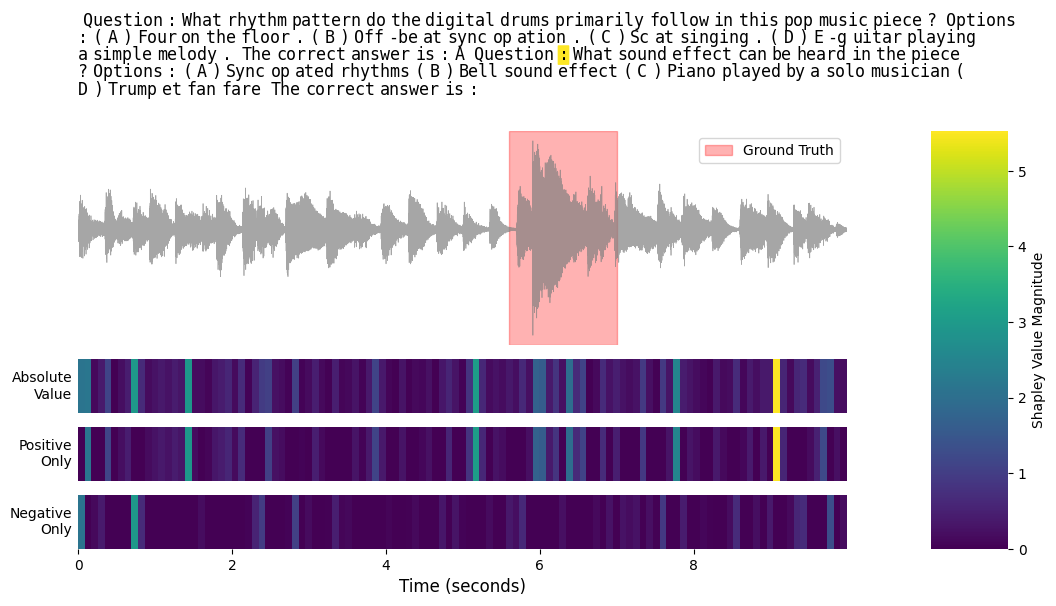

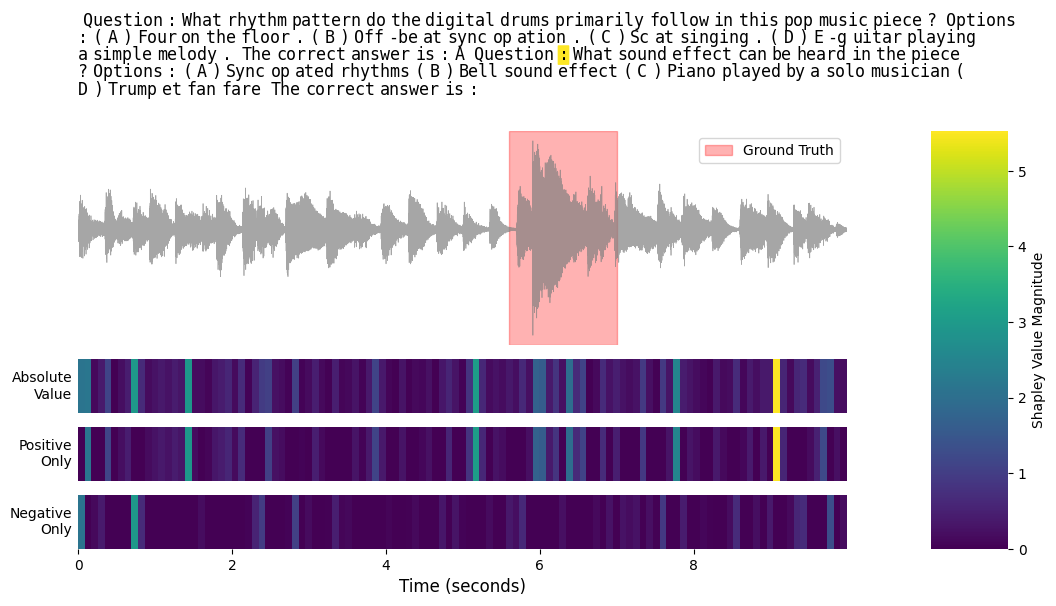

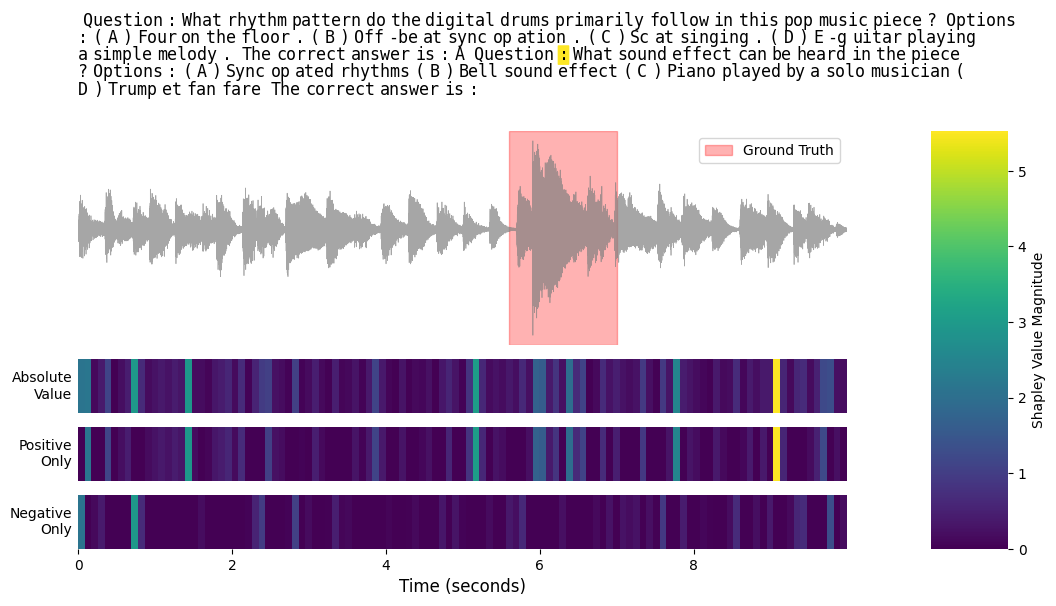

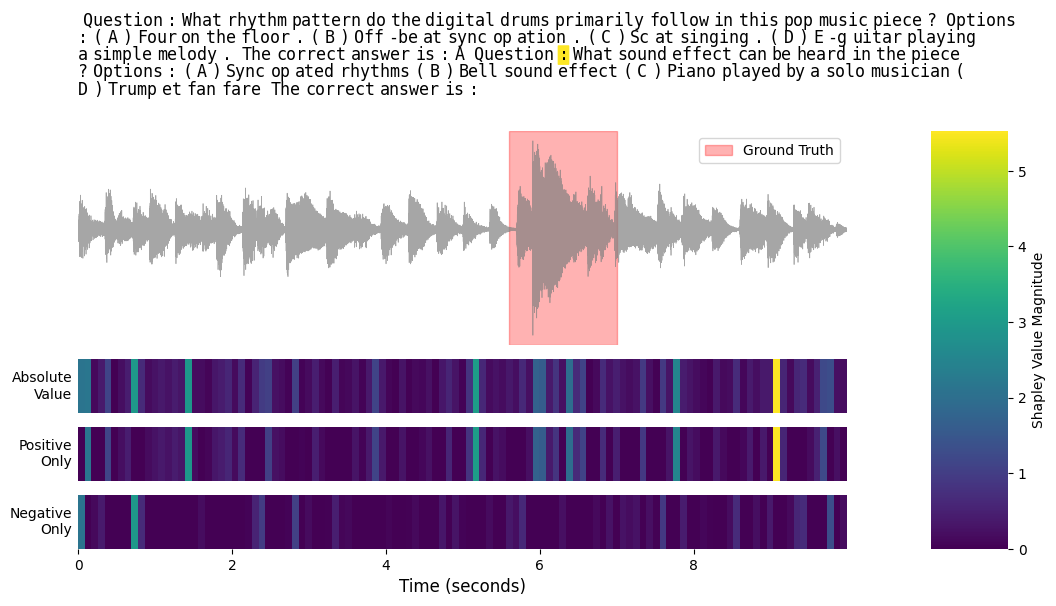

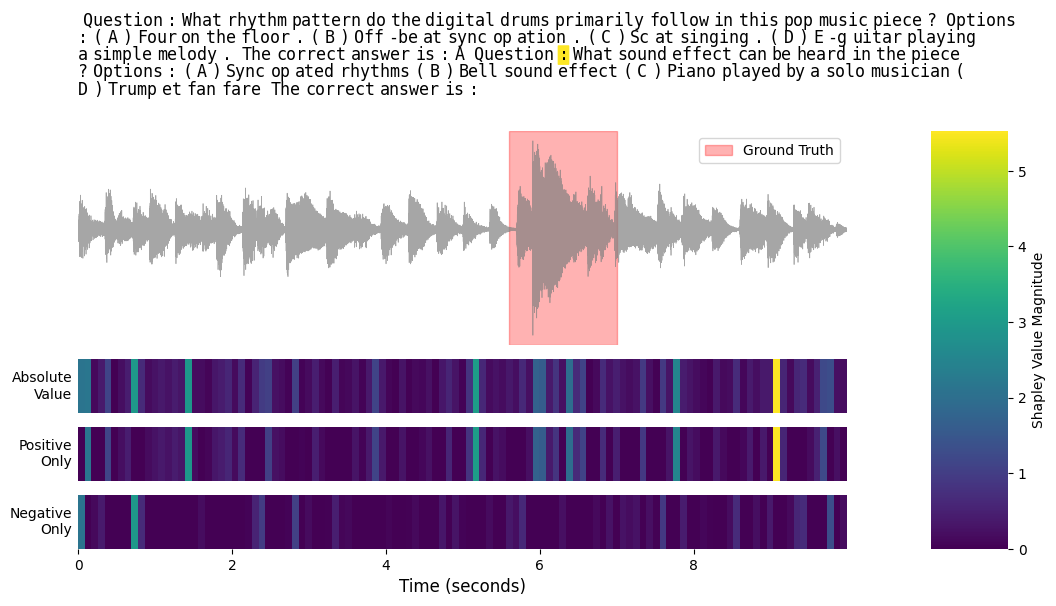

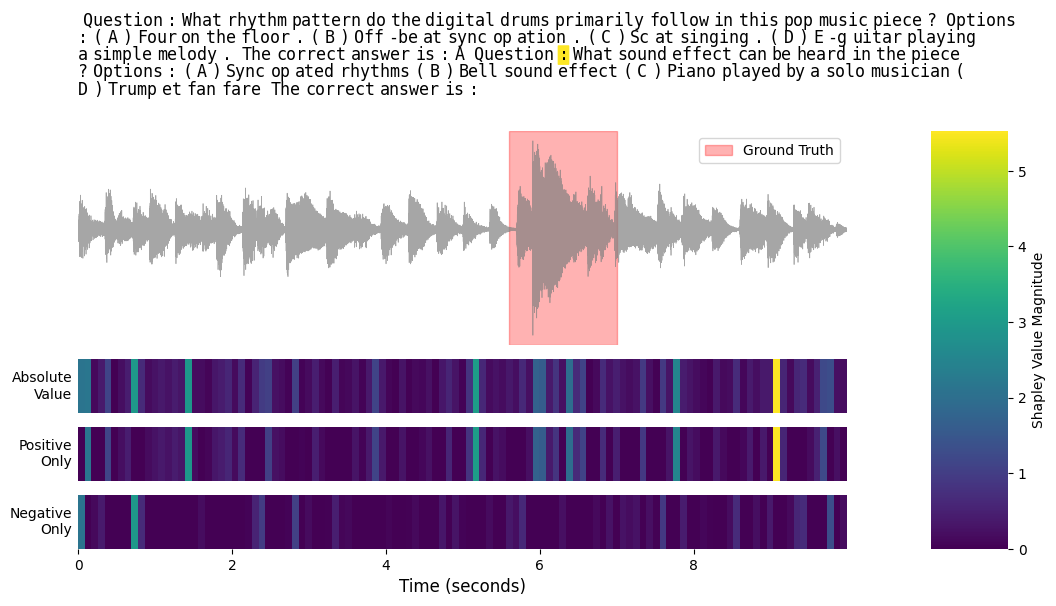

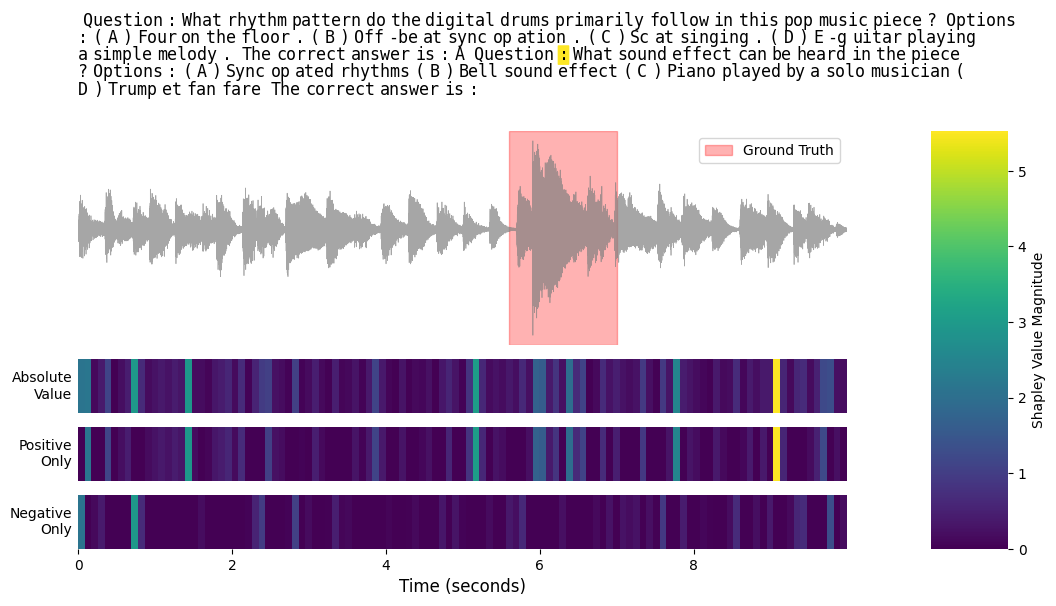

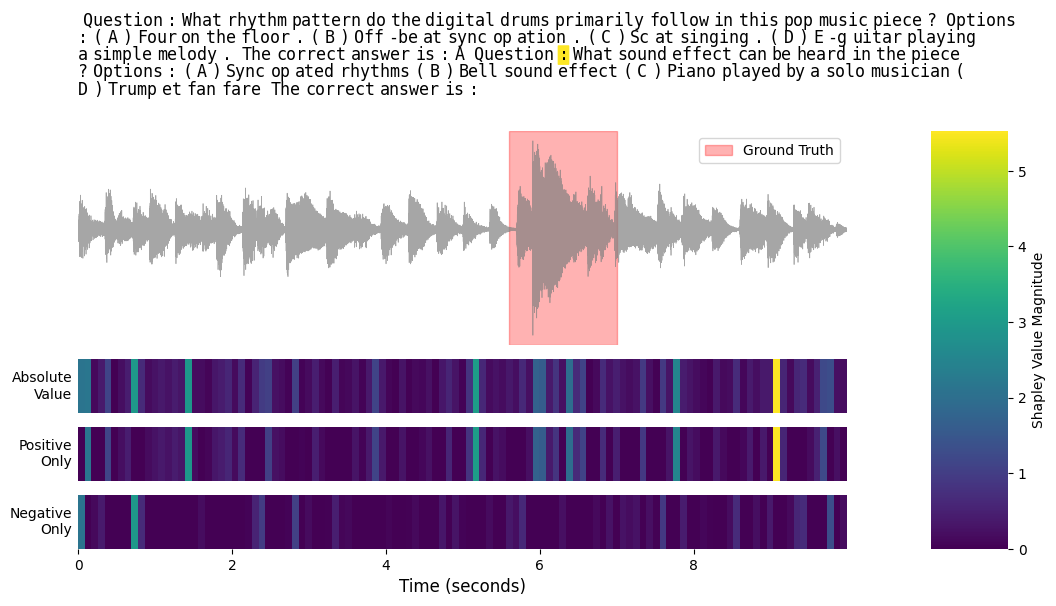

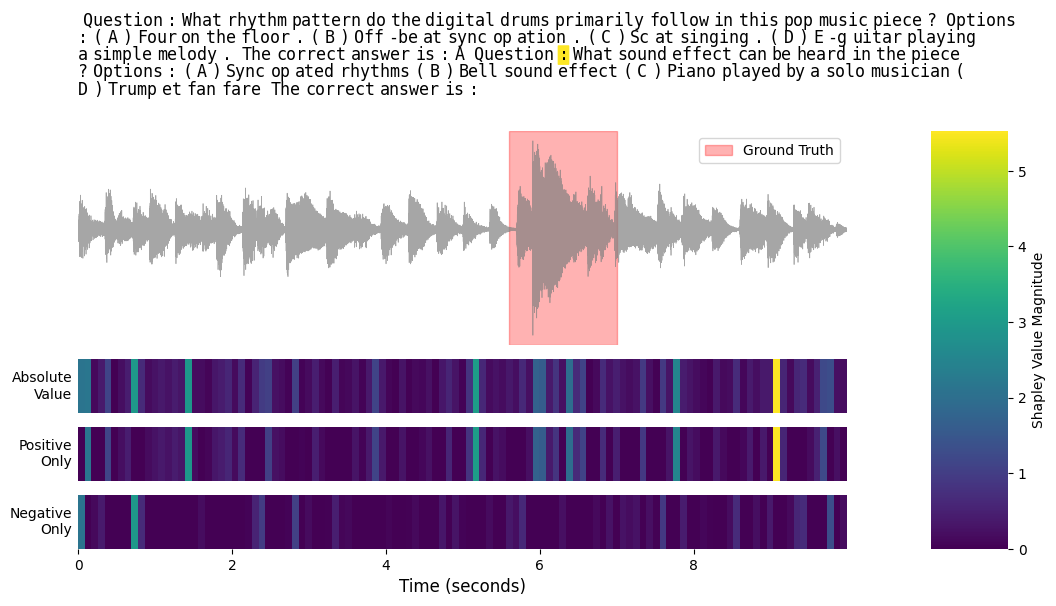

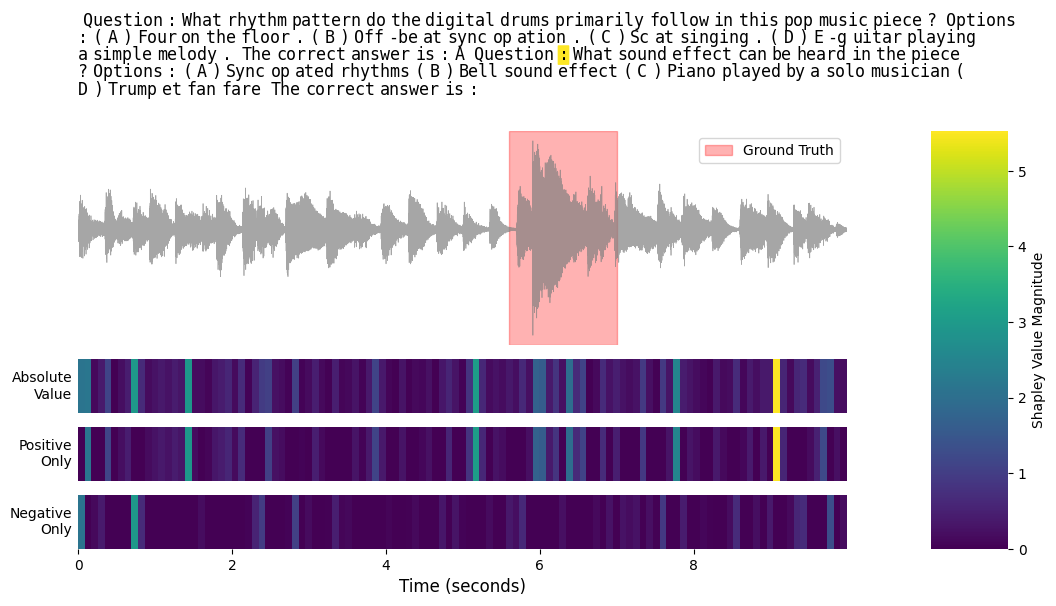

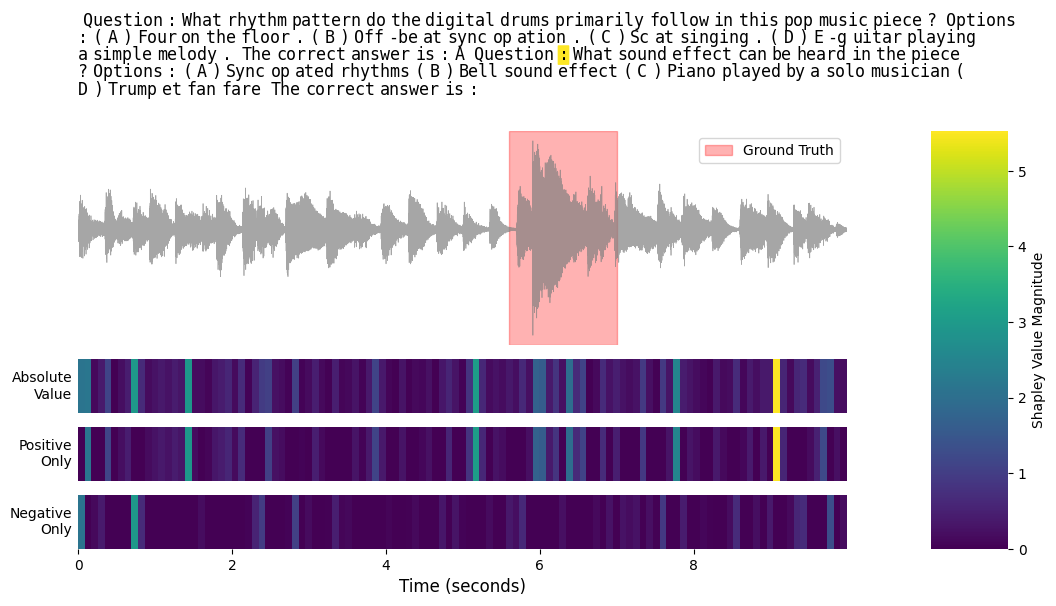

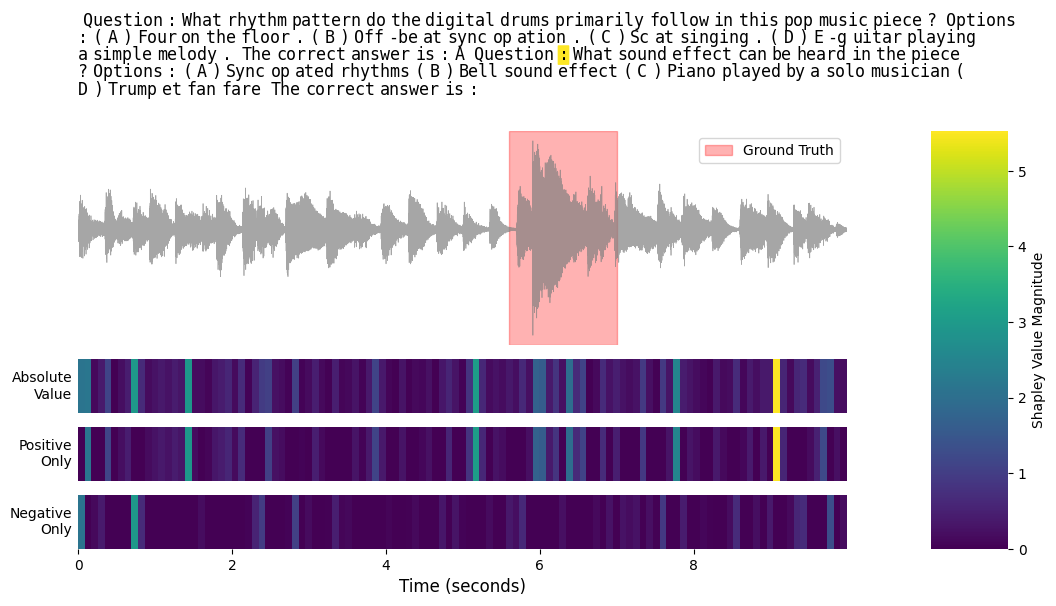

In [139]:
for i, _ in enumerate(sample["output_tokens"]):
    highlighted_text = plots.visualize_shapley_analysis(
            text_shapley_values=question_shapley_values,
            question_tokens=sample["input_tokens"],
            answer_tokens=sample["output_tokens"],
            audio_signal=x,
            audio_shapley_values=audio_shapley_values,
            sample_rate=16000,
            gt_start=gt_start,
            gt_end=gt_end,
            idx=None,
            figsize=(12,7),
            colormap="viridis",
            threshold=0.8
        )

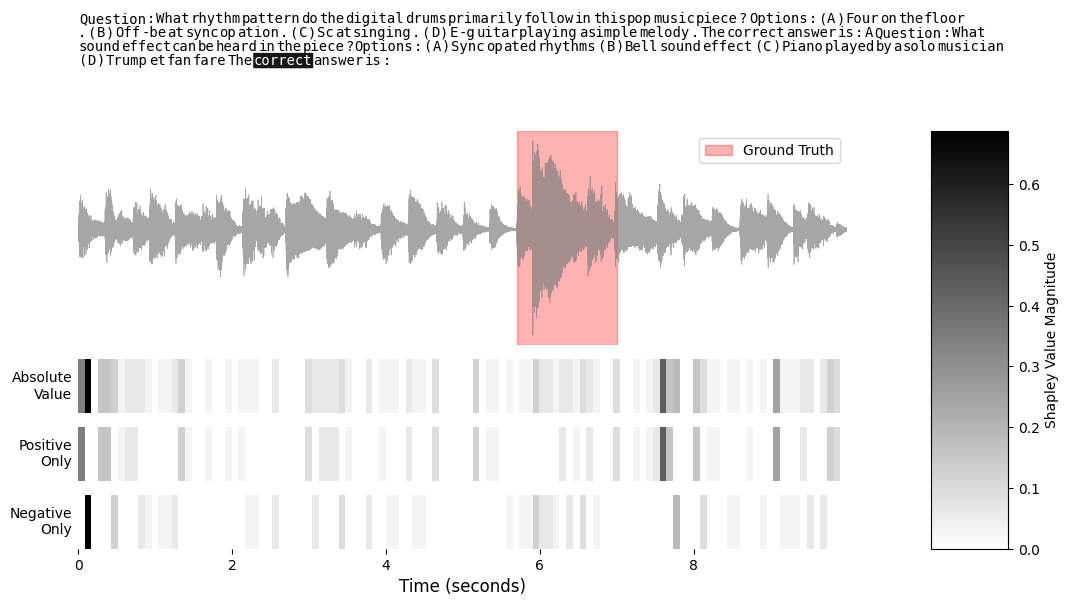

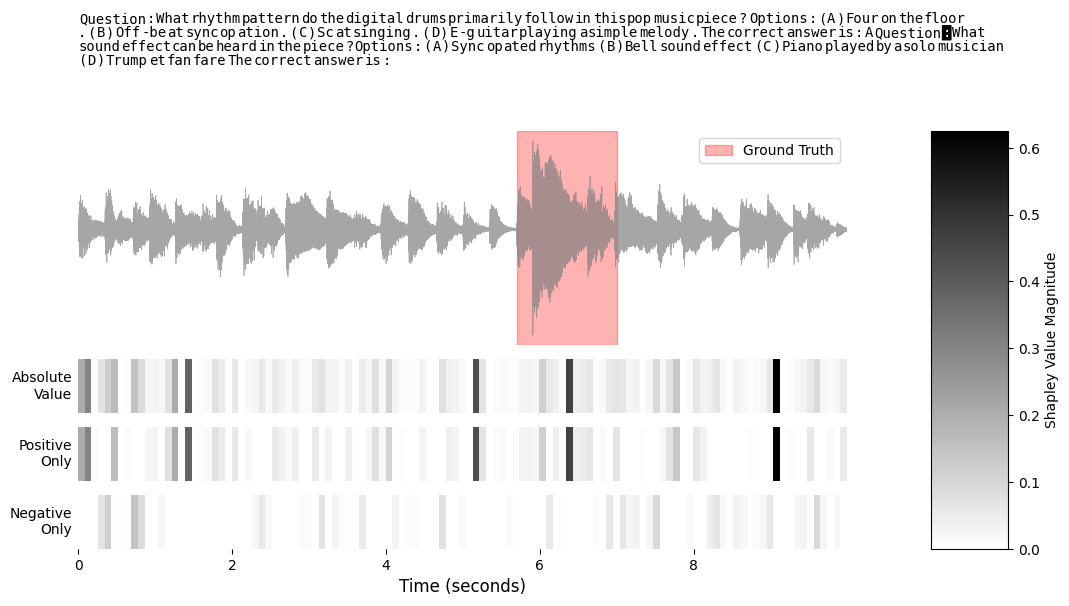

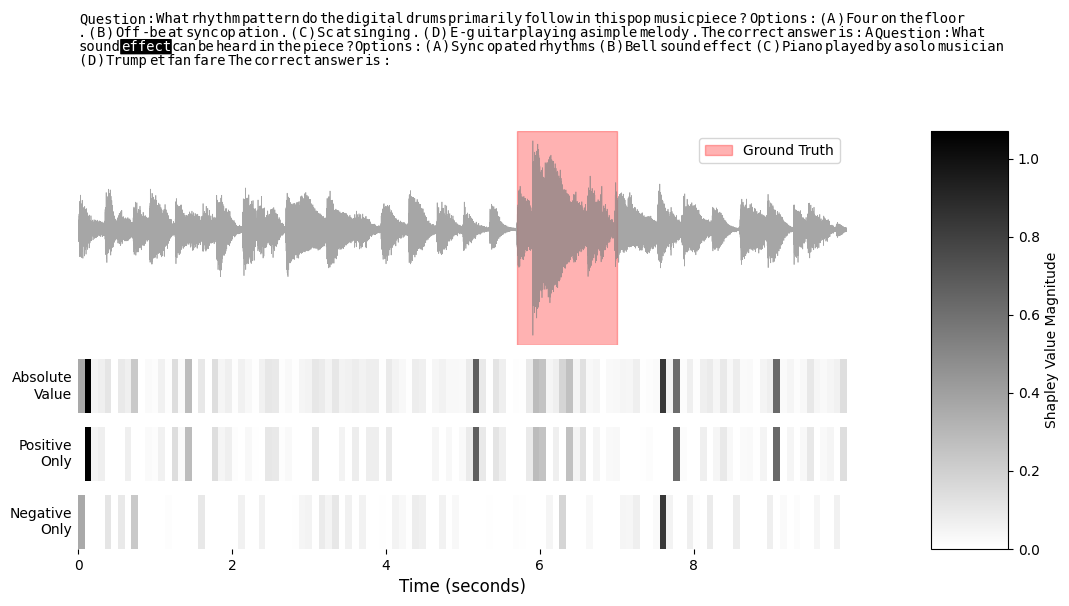

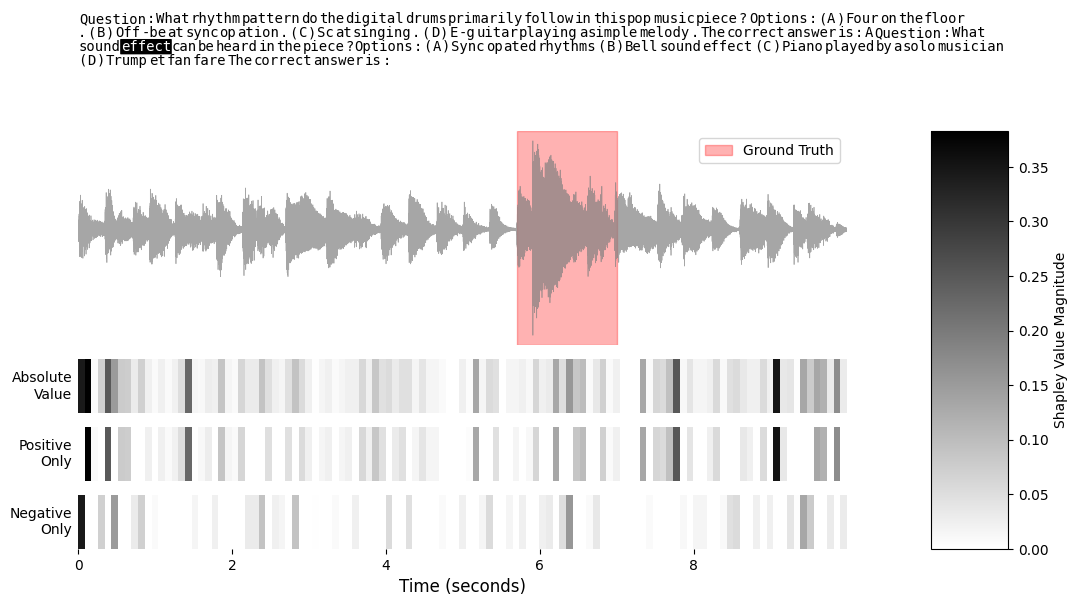

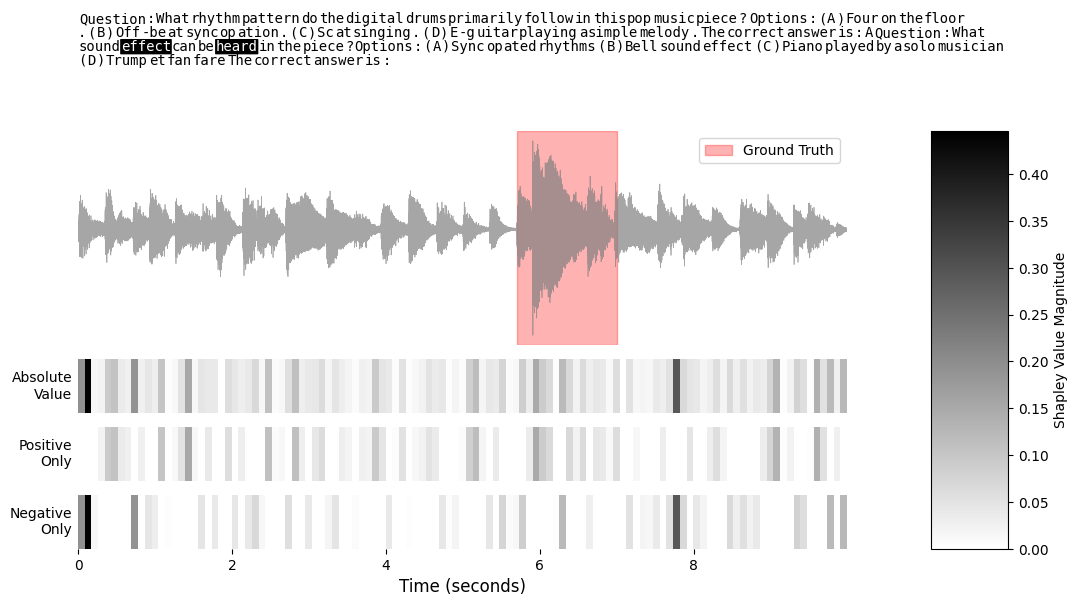

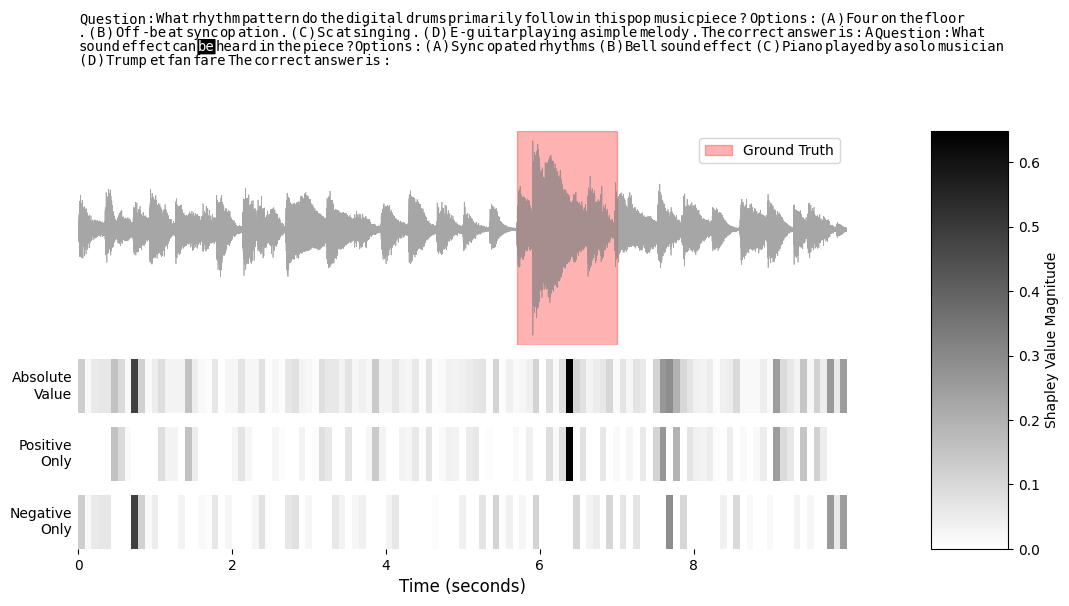

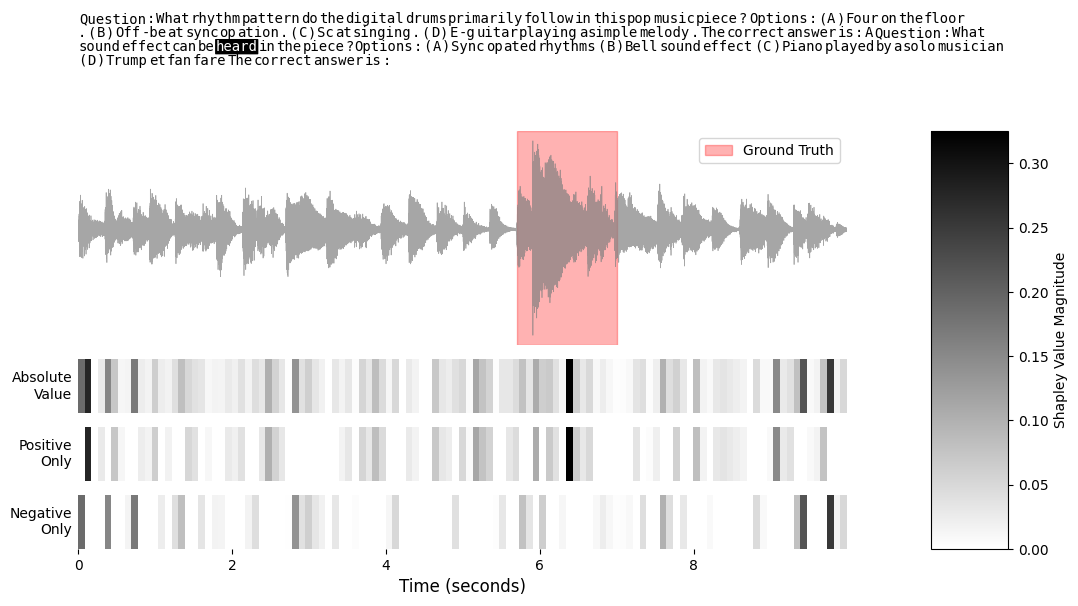

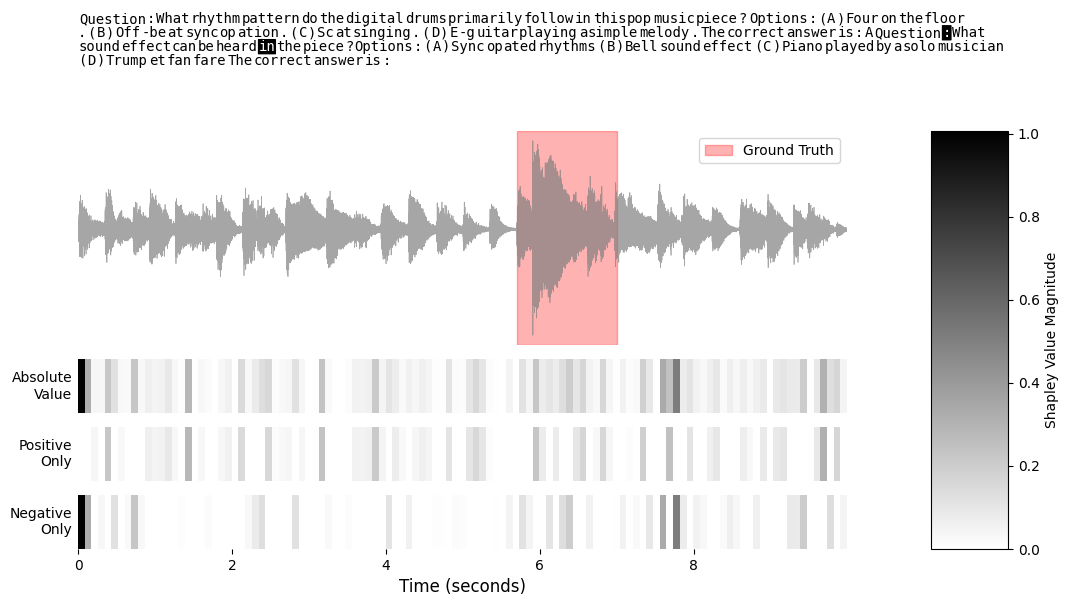

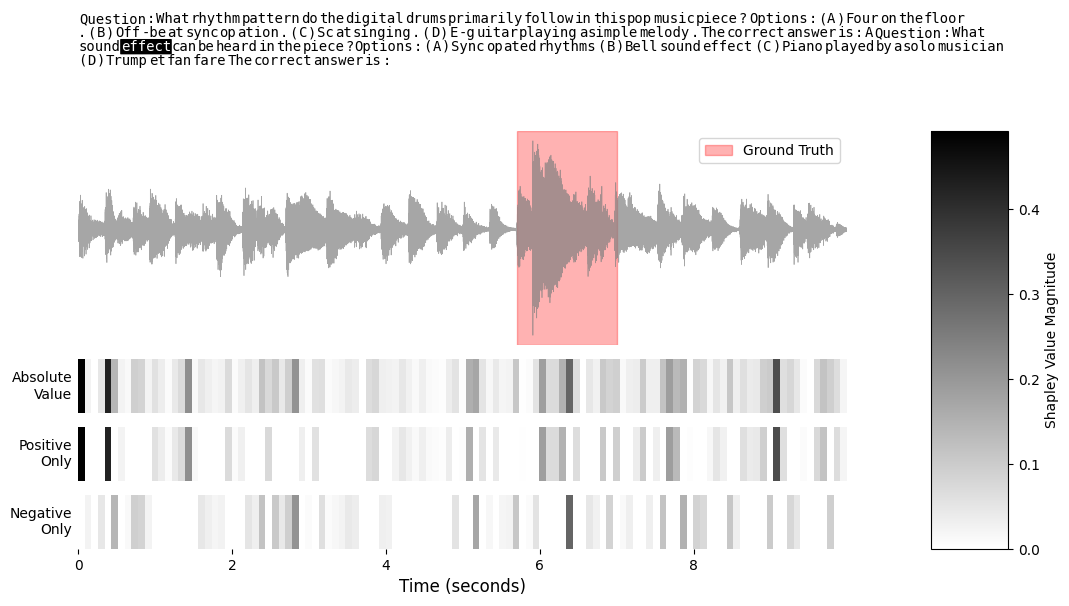

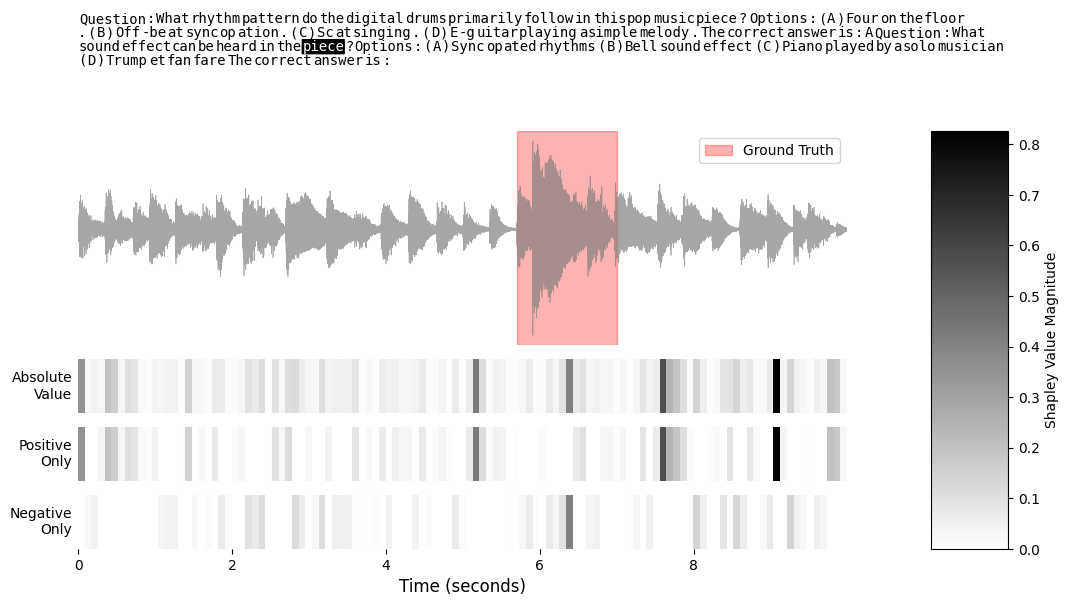

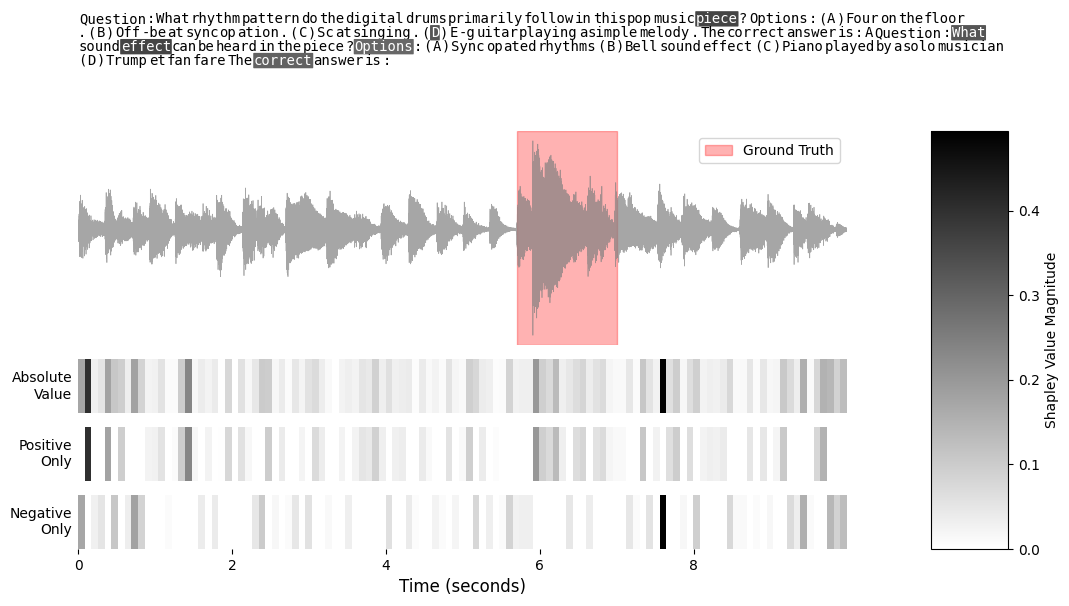

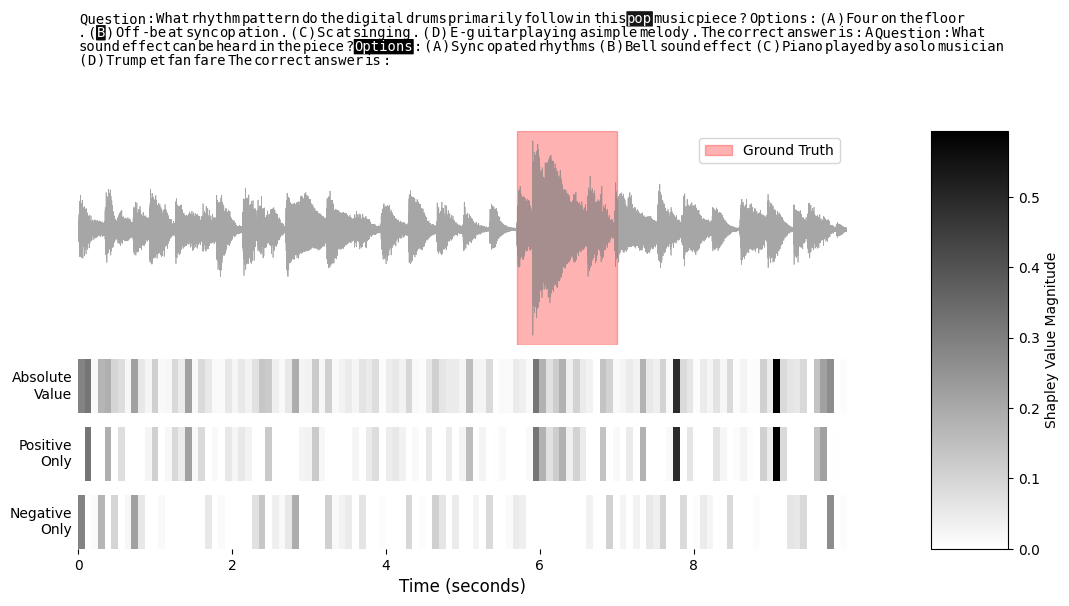

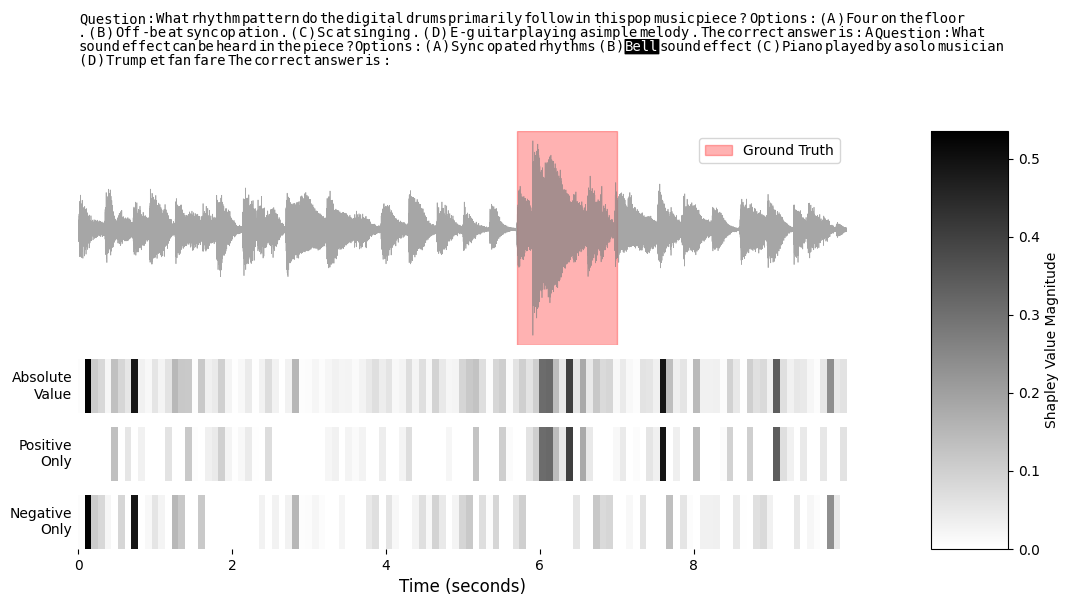

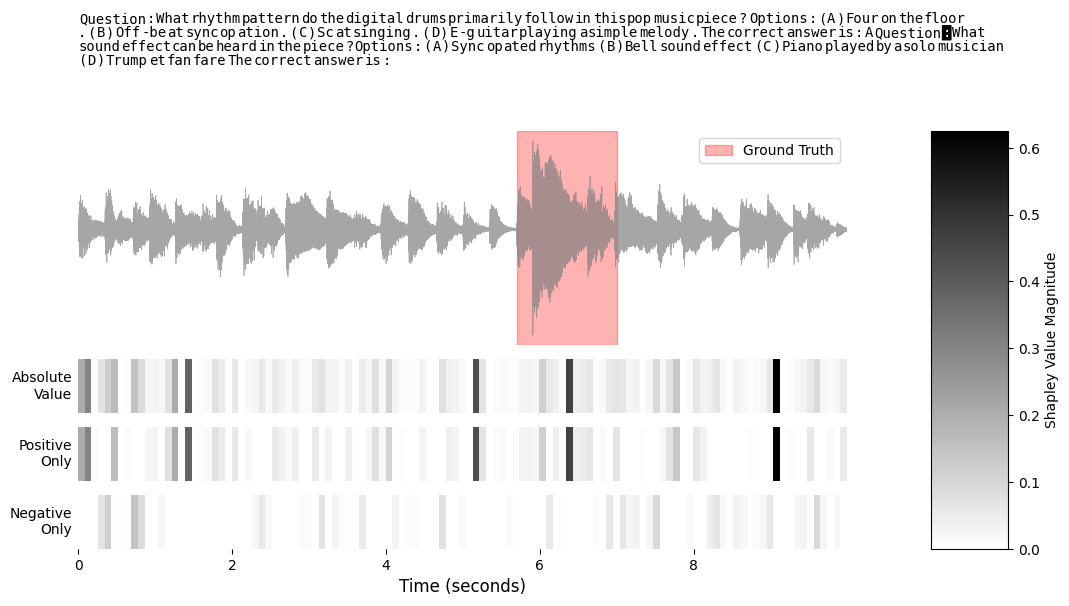

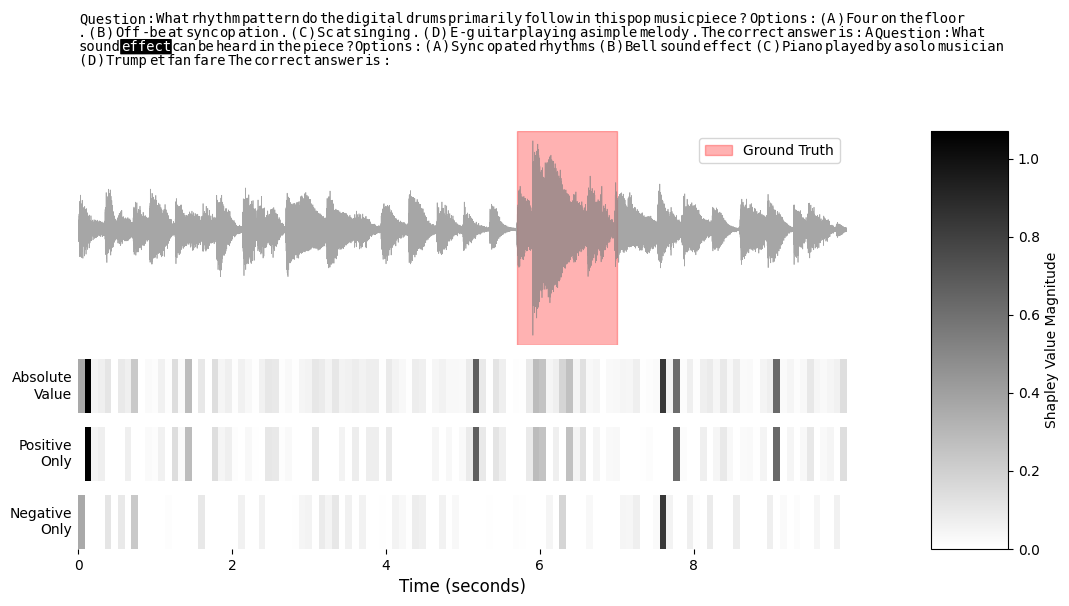

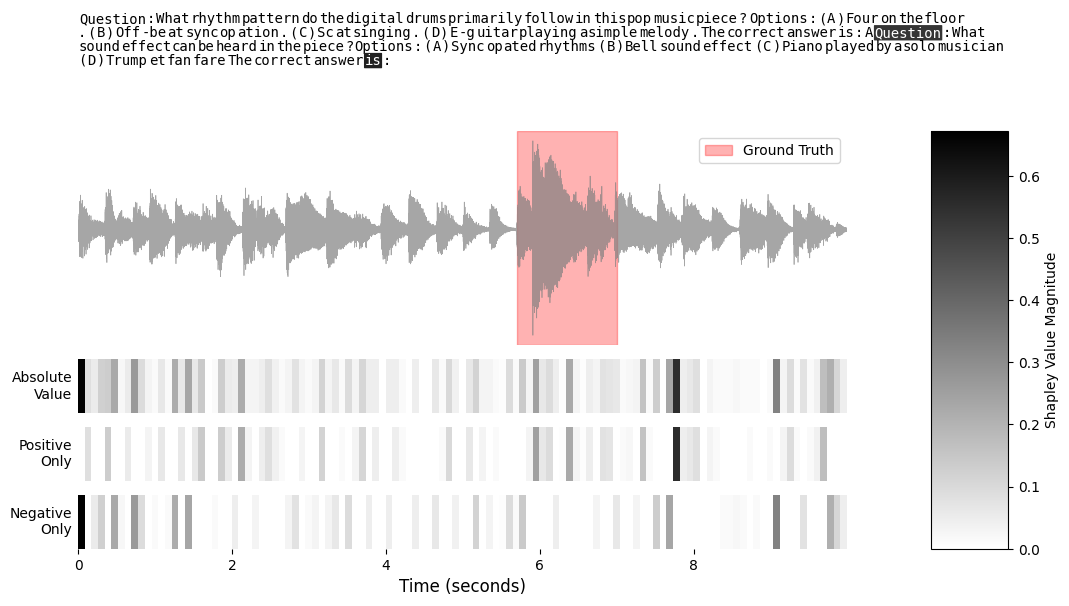

In [111]:
sample = qfs.loc[719] #427
all_shapley_values, audio_shapley_values, question_shapley_values = get_values(qfs.loc[719])

x, fs = librosa.load(os.path.join(dataset_path, sample["audio_path"]), sr=16000)

for i, _ in enumerate(sample["output_tokens"]):
    plots.visualize_shapley_analysis(
            text_shapley_values=question_shapley_values,
            question_tokens=sample["input_tokens"],
            answer_tokens=sample["output_tokens"],
            audio_signal=x,
            audio_shapley_values=audio_shapley_values,
            sample_rate=16000,
            gt_start=5.7,
            gt_end=7,
            idx=i,
            figsize=(12,7),
            colormap="binary",
            threshold=0.8
        )

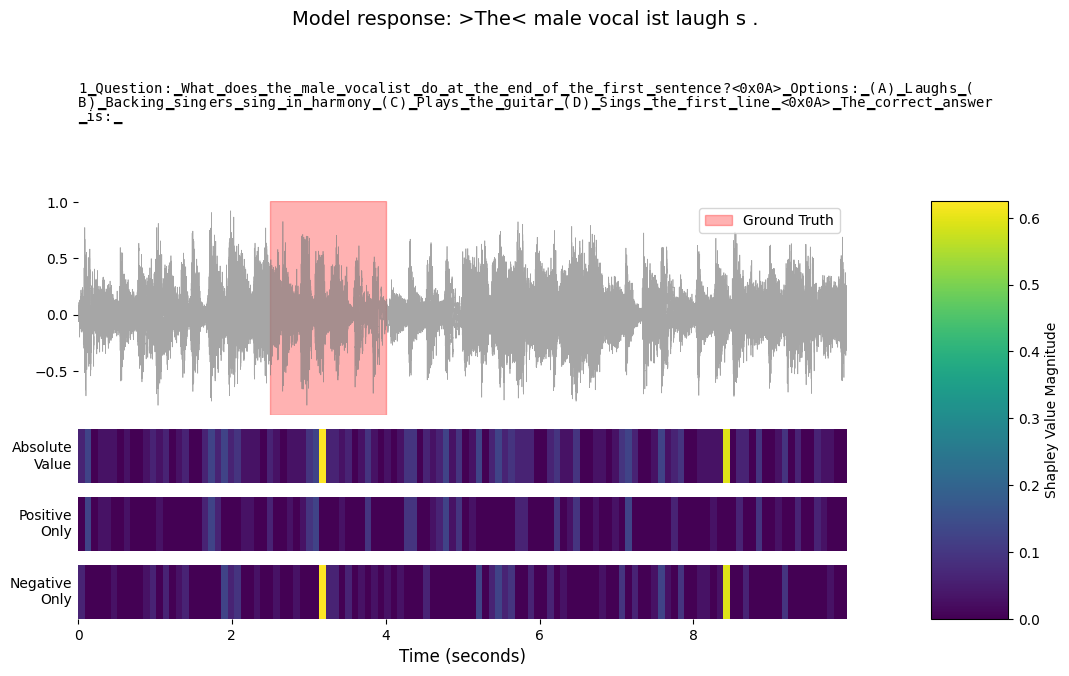

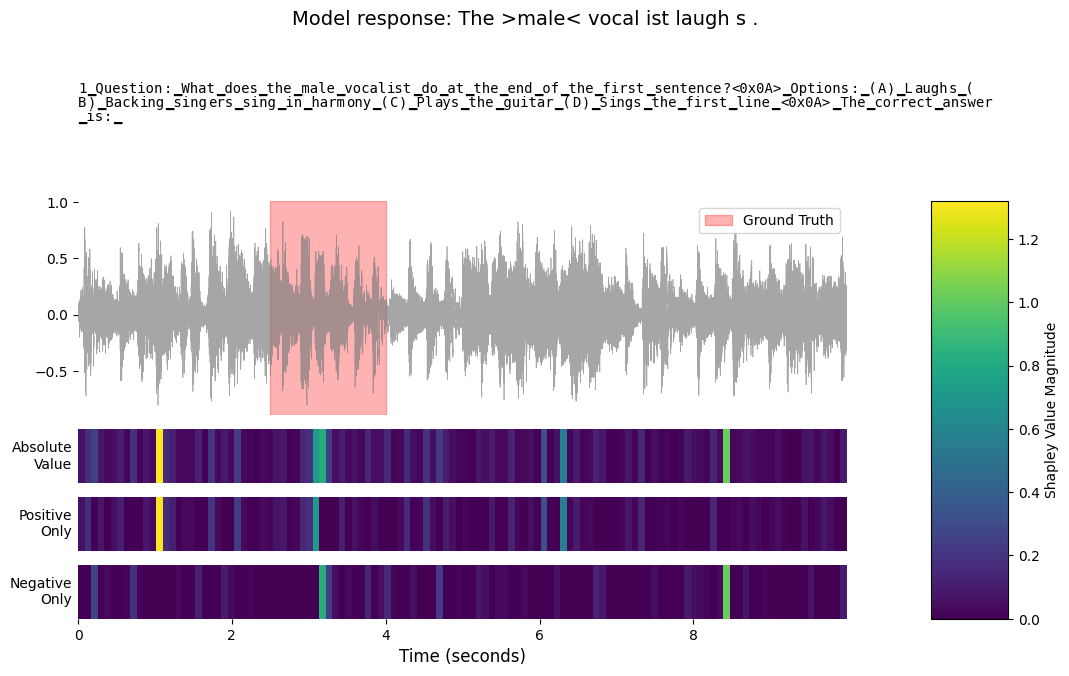

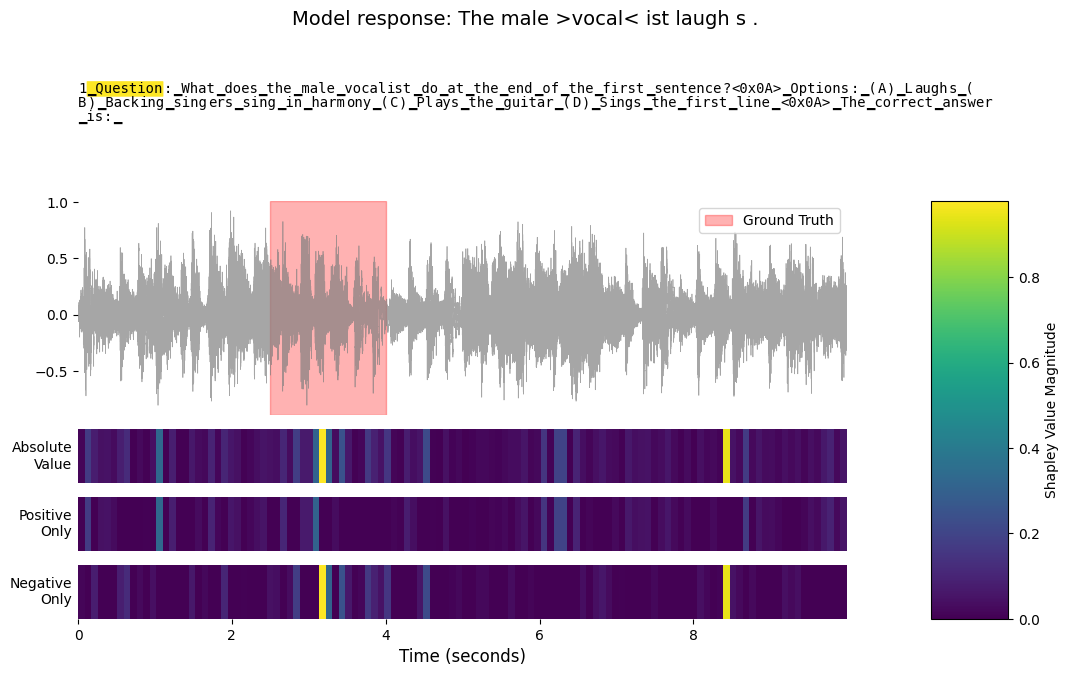

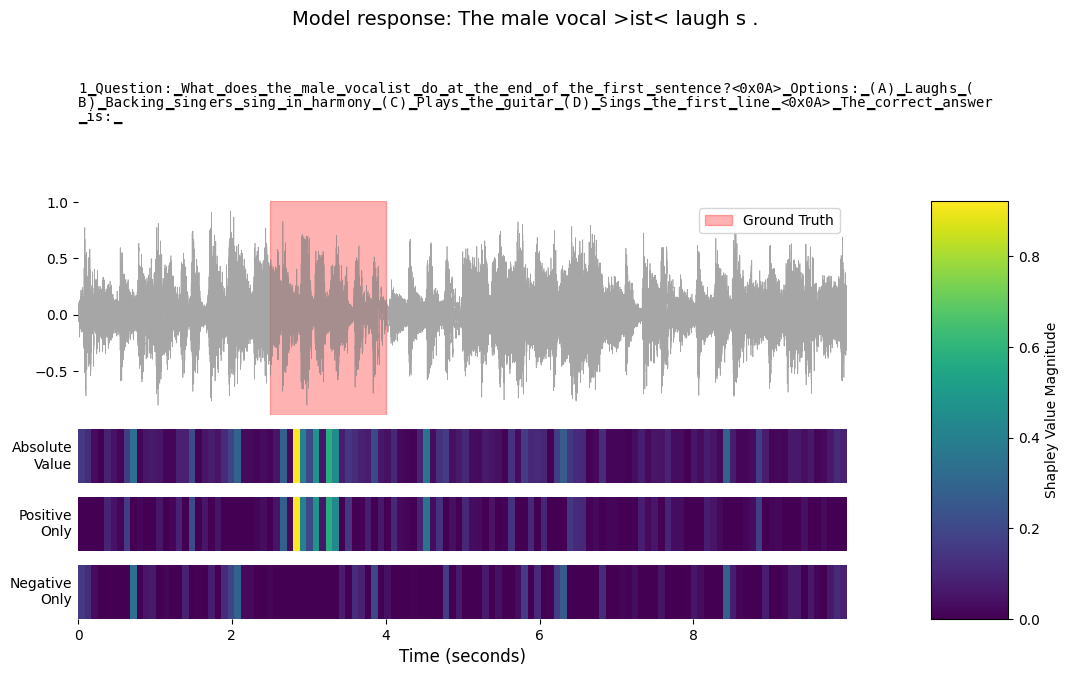

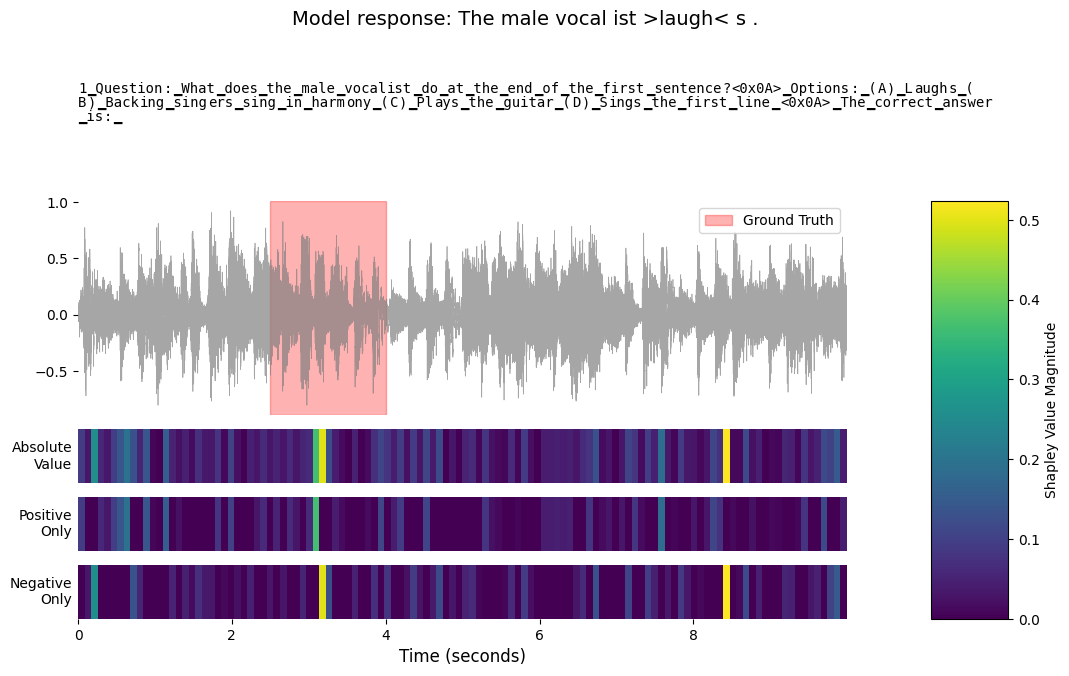

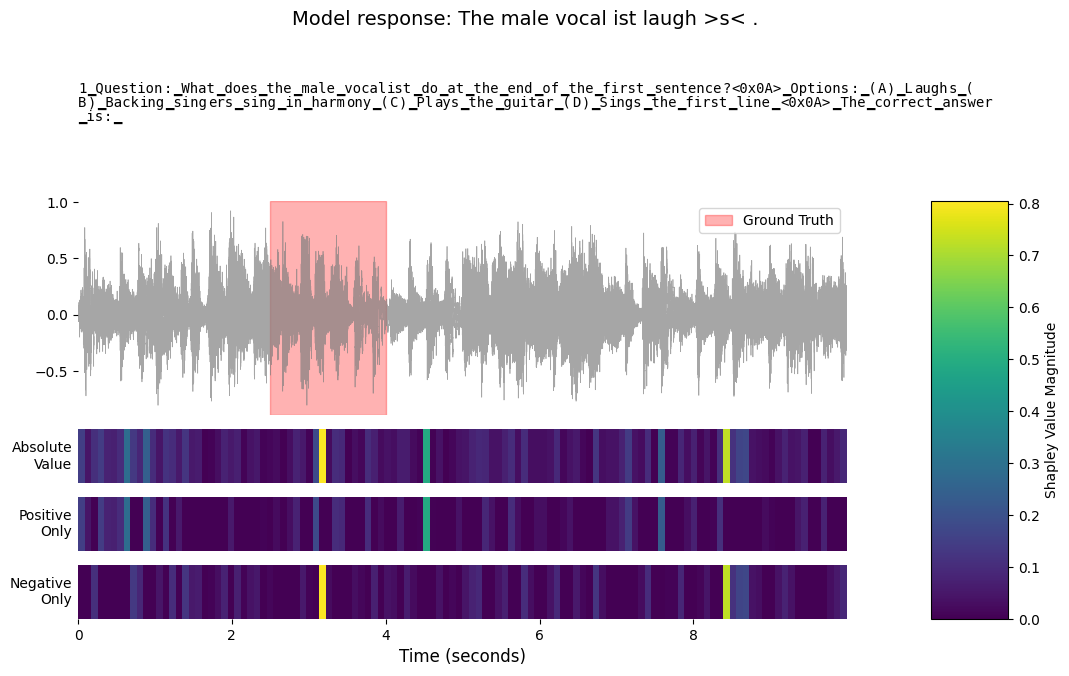

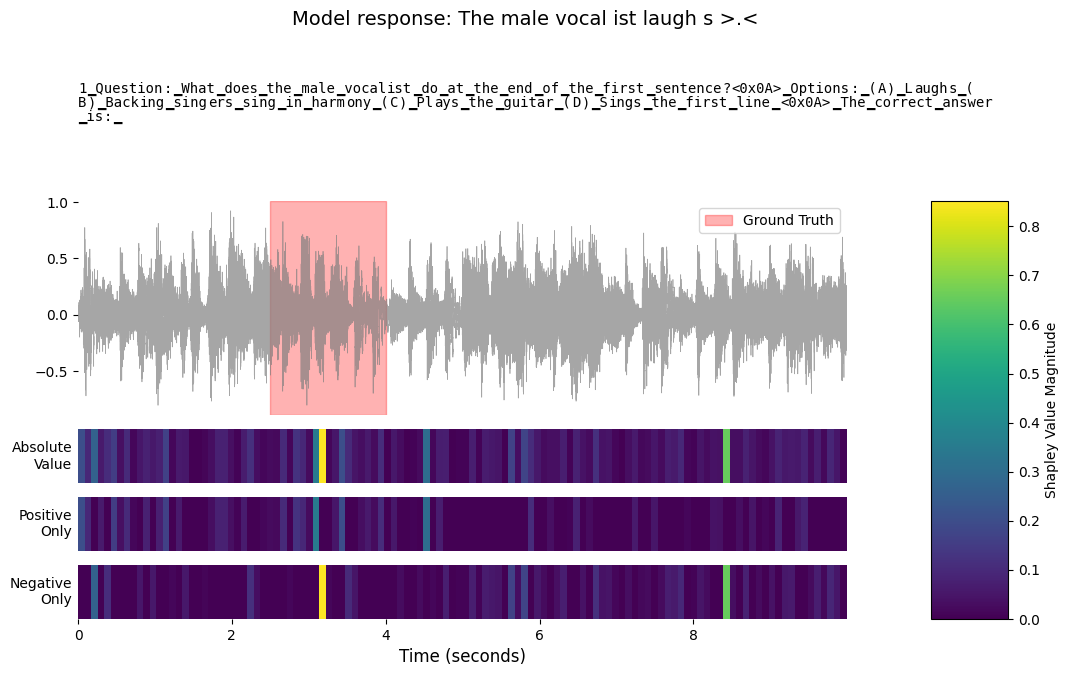

In [81]:
sample = mzs.loc[427]
x, fs = librosa.load(os.path.join(dataset_path, sample["audio_path"]), sr=24000)
for idx, t in enumerate(example["output_tokens"]):
    highlighted_text = plots.visualize_shapley_analysis(
        text_shapley_values=question_shapley_values,
        question_tokens=sample["input_tokens"],
        answer_tokens=sample["output_tokens"],
        audio_signal=x,
        audio_shapley_values=audio_shapley_values,
        sample_rate=24000,
        gt_start=2.5,
        gt_end=4,
        max_abs_value=0.5, # Optional,
        idx=idx,
        figsize=(12,7),
        colormap="viridis",
        threshold=0.7
    )

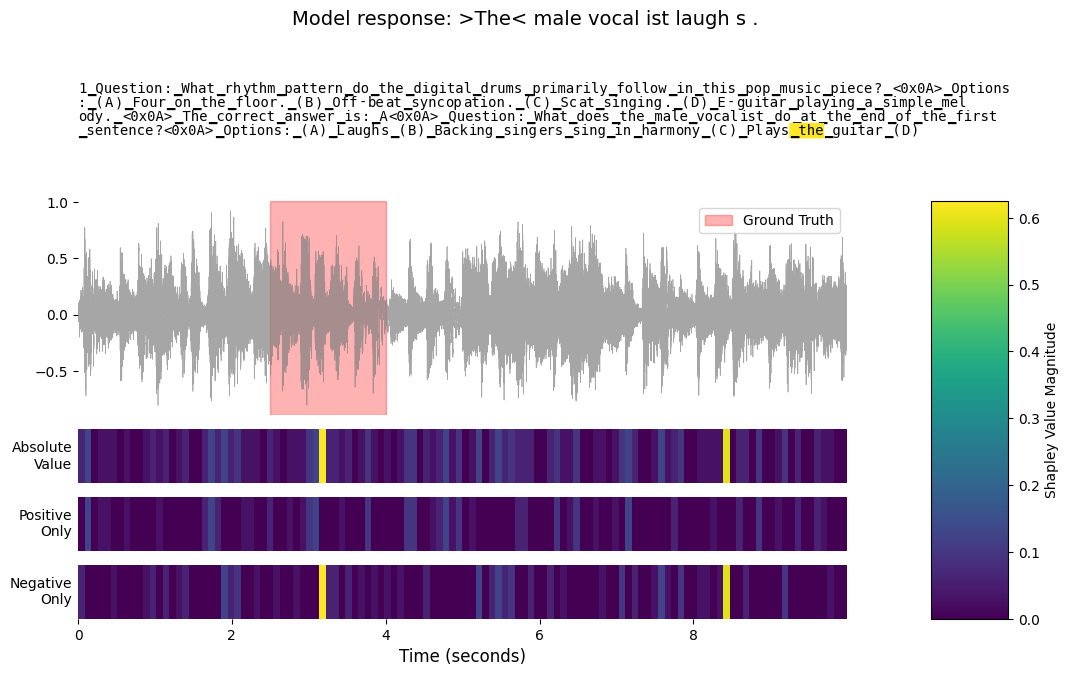

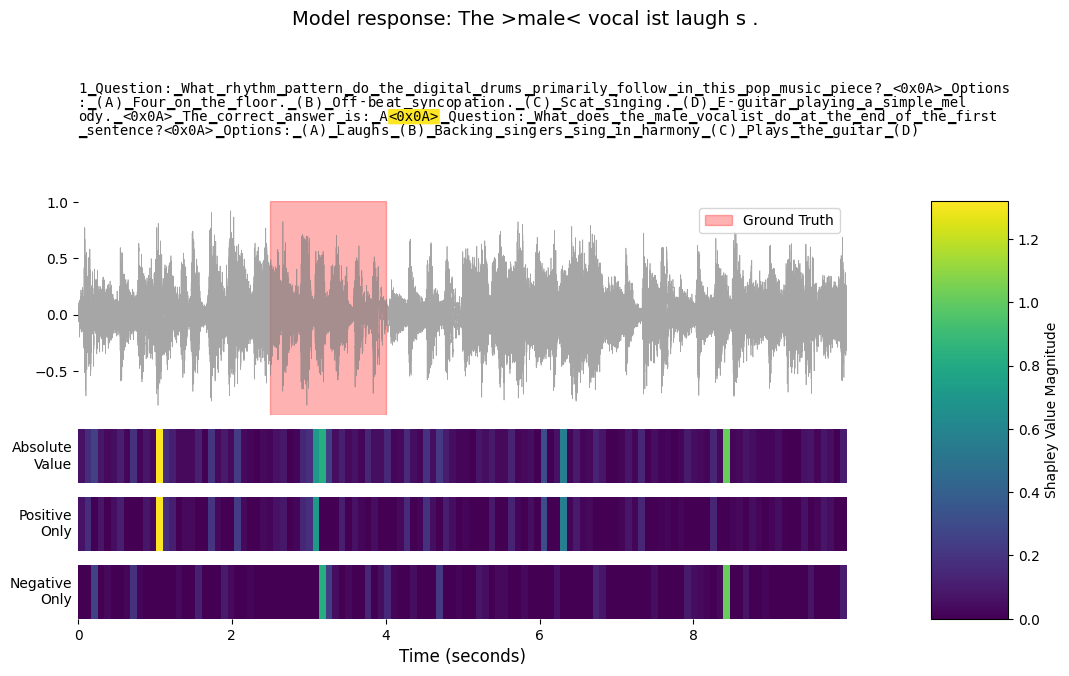

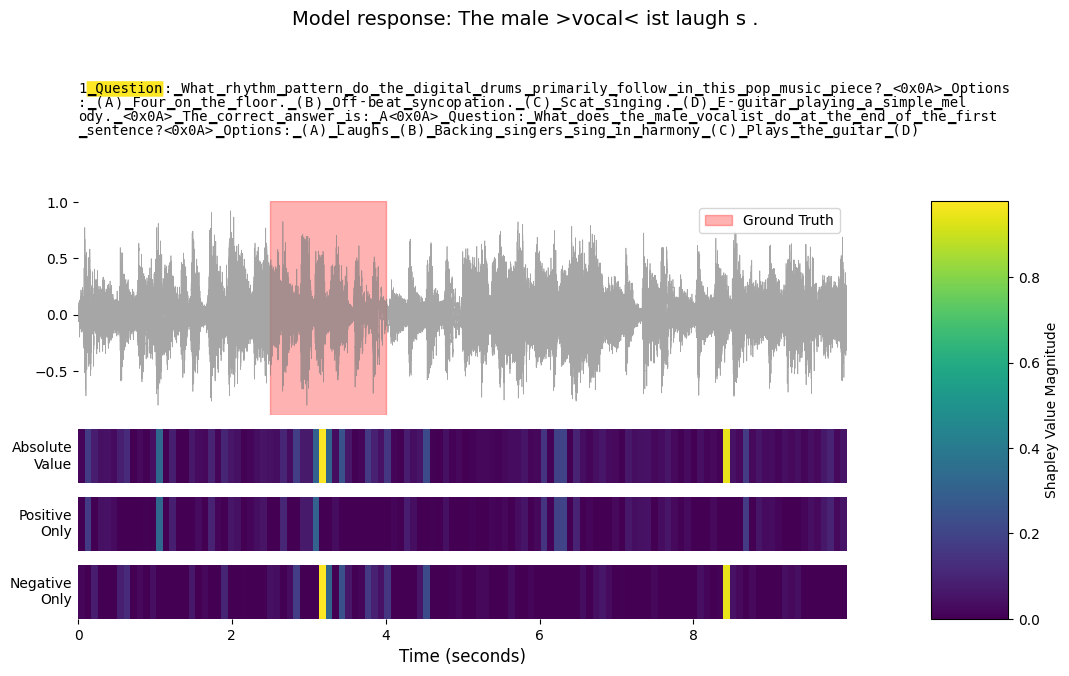

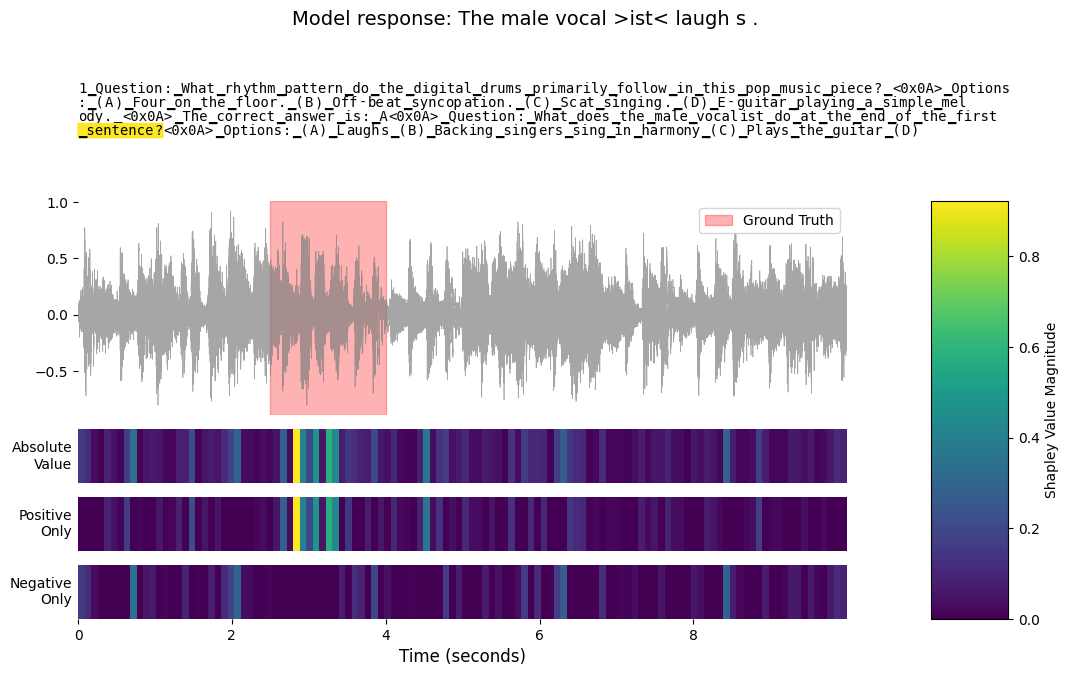

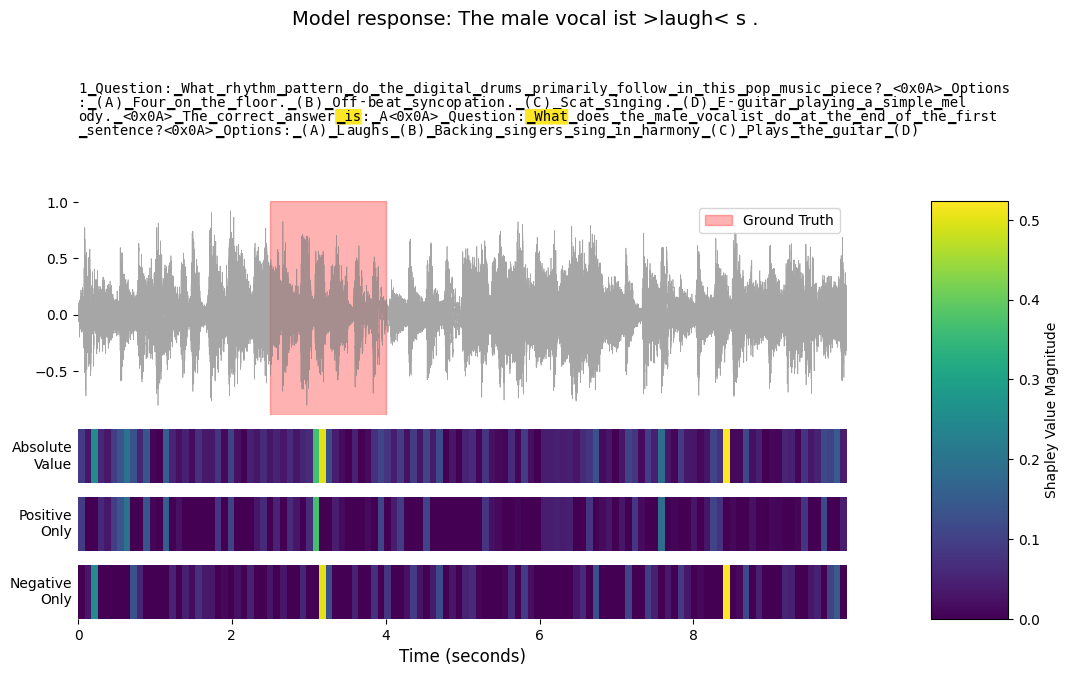

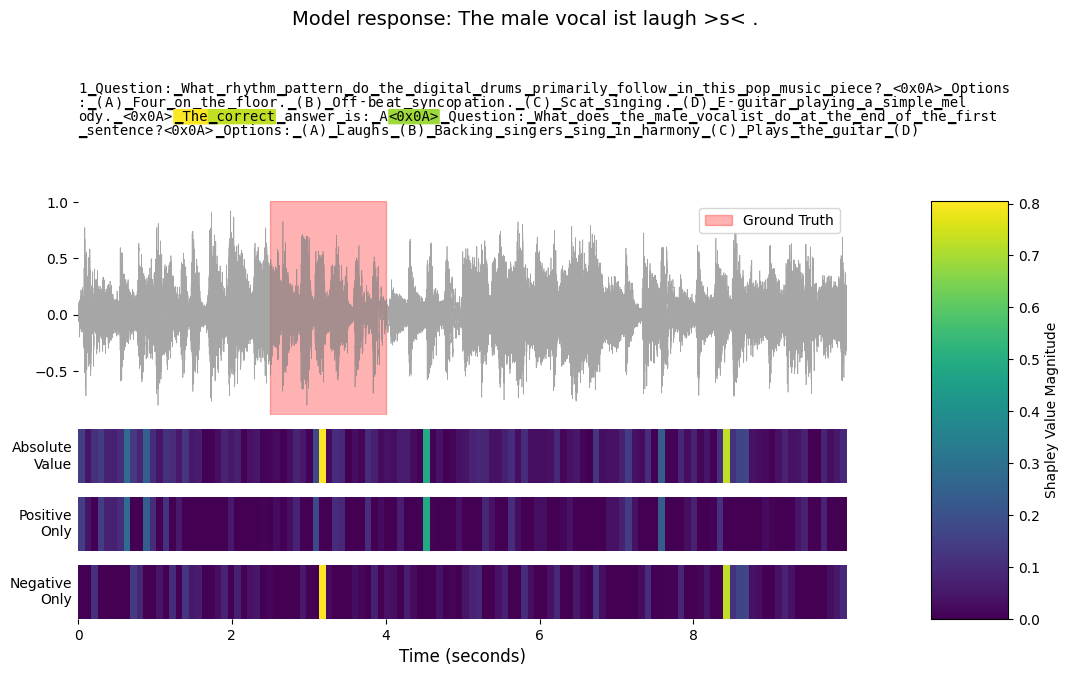

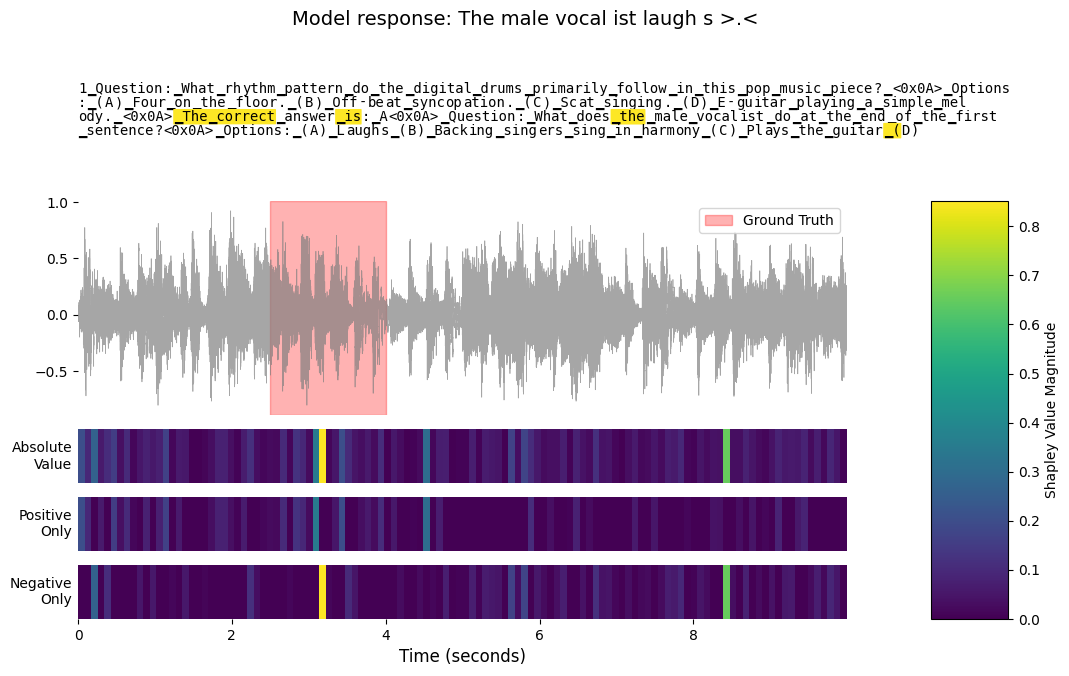

In [79]:
x, fs = librosa.load(os.path.join(dataset_path, sample["audio_path"]), sr=24000)
for idx, t in enumerate(example["output_tokens"]):
    highlighted_text = plots.visualize_shapley_analysis(
        text_shapley_values=question_shapley_values,
        question_tokens=example["input_tokens"],
        answer_tokens=example["output_tokens"],
        audio_signal=x,
        audio_shapley_values=audio_shapley_values,
        sample_rate=24000,
        gt_start=2.5,
        gt_end=4,
        max_abs_value=0.5, # Optional,
        idx=idx,
        figsize=(12,7),
        colormap="viridis",
        threshold=0.7
    )